In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys

main_dir = os.path.dirname(os.path.abspath('../'))
sys.path.insert(0, main_dir)

from forward.fourier import method, kernel_creator

GPU_ID = 1
if torch.cuda.is_available():
    torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")

%load_ext autoreload
%autoreload 2

5 GPU(s) available:
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090
NVIDIA GeForce RTX 3090


### Can we test the fourier kernel?

In [2]:
kernel = kernel_creator.create_fourier_kernel();

#taken from jannik
signalfft_center = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_center.npy')
signalfft_left = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_left.npy')
signalfft_right = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230508_mask_analysis_talbot_0_300us/signalfft_padded_right.npy')

signal_fft = np.concatenate((signalfft_left,signalfft_center,signalfft_right),axis = 1)

wavls = np.load('/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/gratings_wavelengths.npy')
wavelengths = np.arange(750,851,5)
idx = np.zeros_like(wavelengths)
for i in np.arange(len(wavelengths)):
    idx[i] = (np.abs(wavls - wavelengths[i]*1e-9)).argmin()

wavls_21 = wavls[idx]
signal_fft_21 = signal_fft[:,:,idx]

signal_fft_21 = signal_fft_21 / np.max(signal_fft_21)


/tmp/user/25186/ipykernel_1747395/2817309728.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel9 = torch.tensor(kernel).unsqueeze(0).permute(0,3,1,2)


Text(0.5, 1.0, 'Recovered')

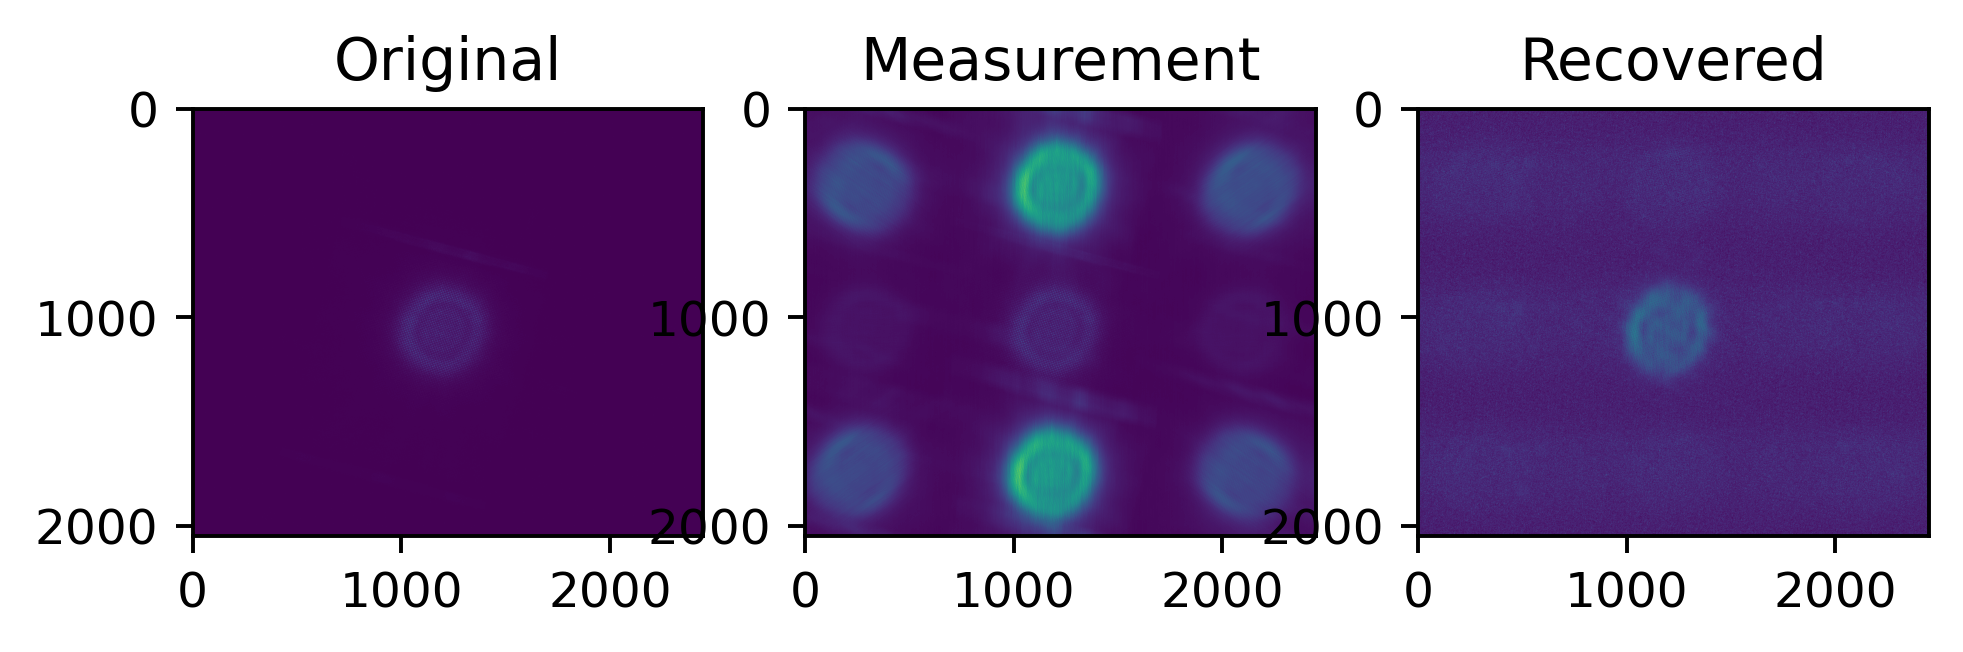

In [3]:
#simulate the measurement
cube = torch.tensor(signal_fft_21).unsqueeze(0).permute(0,3,1,2)
kernel9 = torch.tensor(kernel).unsqueeze(0).permute(0,3,1,2)

shift_info = {'kernel':kernel9}

measurement = torch.abs(method.calc_psi_z(torch.ones_like(cube),cube,shift_info))
recovered = torch.abs(method.calc_psiT_g(torch.ones_like(cube),measurement,shift_info))

fig,ax = plt.subplots(1,3,dpi=350)
ax[0].imshow(cube[0,10,:]);ax[0].set_title('Original')
ax[1].imshow(measurement[0]); ax[1].set_title('Measurement')
ax[2].imshow(recovered[0,10,:]); ax[2].set_title('Recovered')


## A bit messy. What can we do if we incorperate the mask information into the model?

Text(0.5, 1.0, 'new recon')

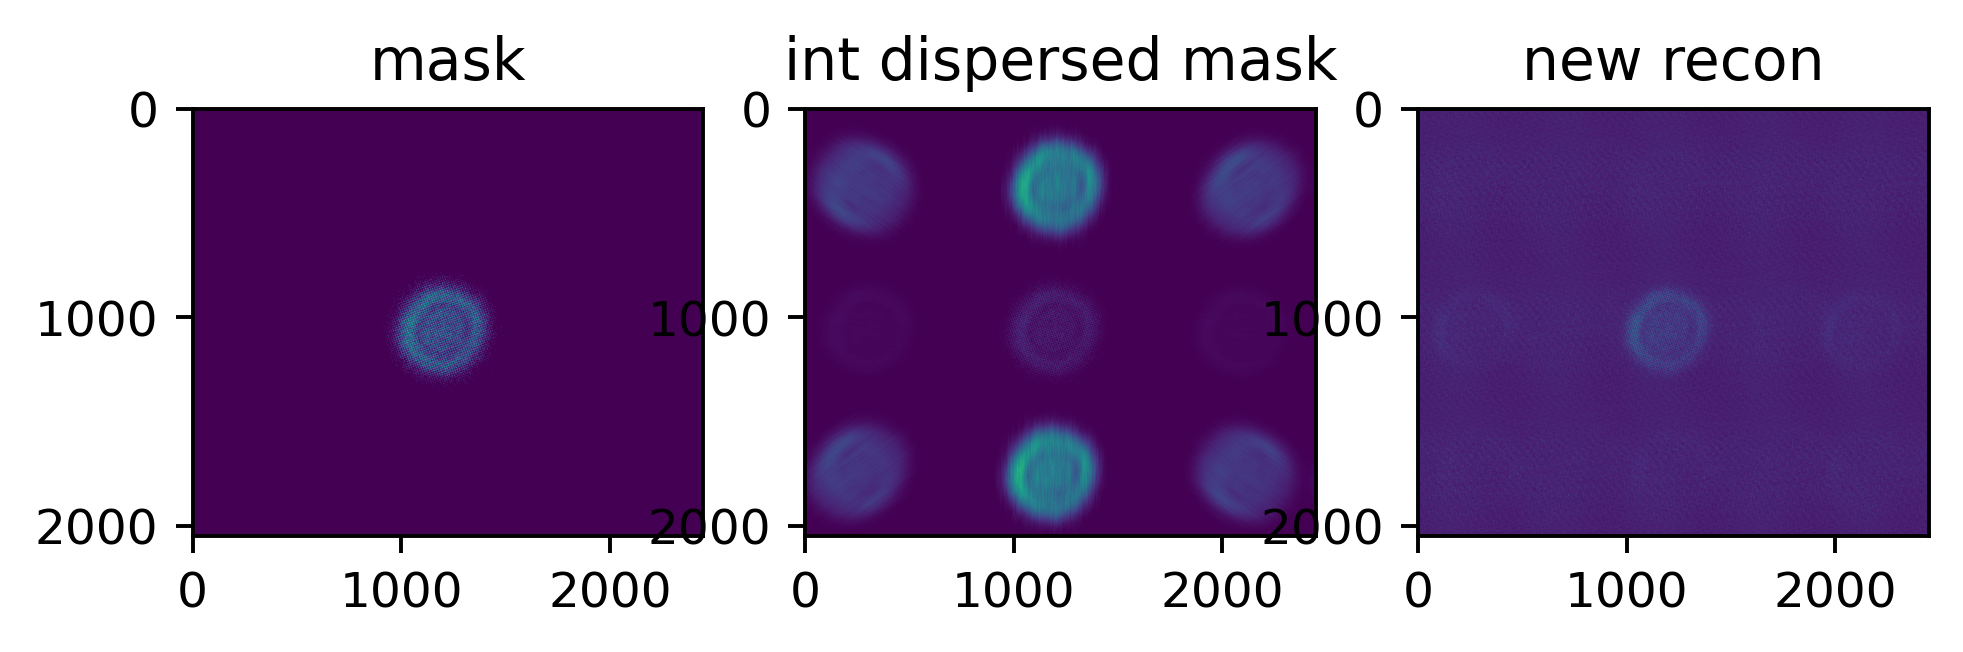

In [4]:
#make a bullshit mask
flat_cube = torch.sum(cube,dim=1)
mask = (flat_cube>0.1*torch.max(flat_cube)).unsqueeze(1).float()
mask = torch.tile(mask,(1,21,1,1))


#disperse it
dispersed_mask = torch.abs(method.disperser.disperse_all_orders(mask,kernel9))
dispersed_mask[dispersed_mask<0.01] = 0


recovered = torch.abs(method.calc_psiT_g(dispersed_mask,measurement,shift_info))

fig,ax = plt.subplots(1,3,dpi=350)

ax[0].imshow(mask[0,10,:]); ax[0].set_title('mask')
ax[1].imshow(torch.sum(dispersed_mask,dim=1)[0]); ax[1].set_title('int dispersed mask')
ax[2].imshow(recovered[0,10,:]); ax[2].set_title('new recon')

padding doesnt work :()

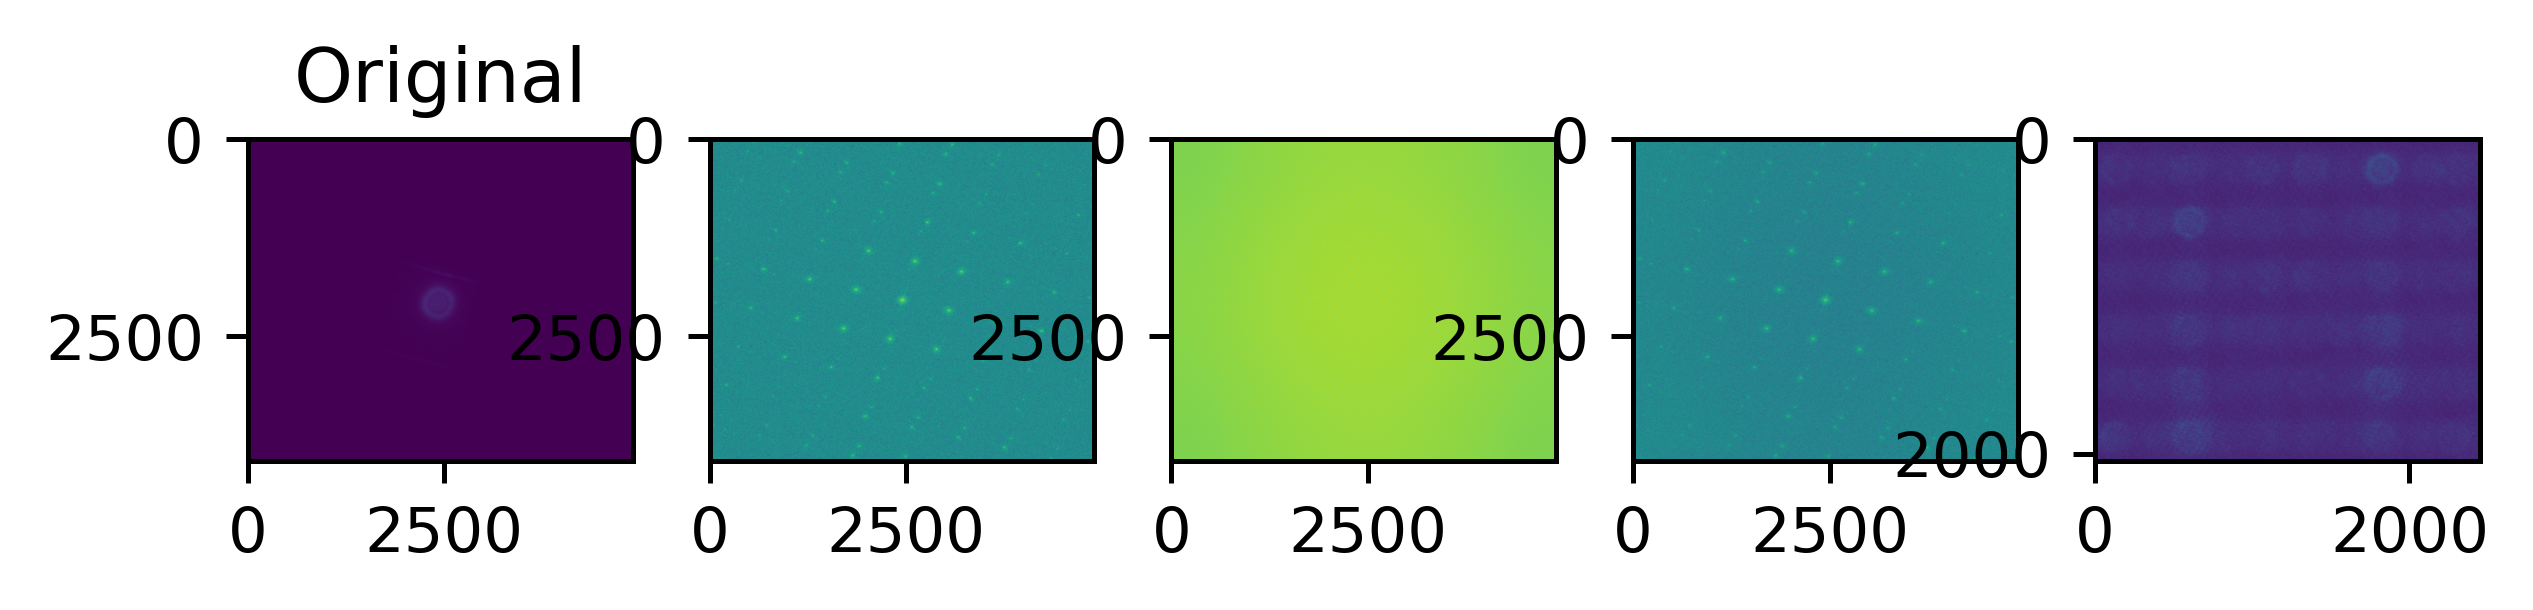

In [80]:
nx,ny = cube.shape[2:]
pad_x = int(np.ceil(nx/2))
pad_y = int(np.ceil(ny/2))
pad_cube = torch.nn.functional.pad(cube,(pad_y,pad_y,pad_x,pad_x))
pad_kernel = torch.nn.functional.pad(kernel9,(pad_y,pad_y,pad_x,pad_x))

# f_cube = torch.fft.fft2(pad_cube)
# f_kernel = torch.fft.fft2(pad_kernel)
# f_cube_undisp = f_cube / f_kernel
# cube_undisp = torch.fft.ifft2(f_cube_undisp)

f_cube = torch.fft.fft2(cube, s = (nx*2,ny*2))
f_kernel = torch.fft.fft2(kernel9, s = (nx*2,ny*2))
f_cube_undisp = f_cube / f_kernel
cube_undisp = torch.fft.ifft2(f_cube_undisp, s = (nx,ny))


fig,ax = plt.subplots(1,5,dpi=450)
ax[0].imshow(pad_cube[0,10,:]);ax[0].set_title('Original')
ax[1].imshow(np.log10(np.abs(torch.fft.fftshift(f_cube)))[0,10])
ax[2].imshow(np.log10(np.abs(torch.fft.fftshift(f_kernel)))[0,10])
ax[3].imshow(np.log10(np.abs(torch.fft.fftshift(f_cube_undisp)))[0,10])
ax[4].imshow(np.abs(cube_undisp)[0,10,:])